In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error as mse
import transformers
import re
from sklearn.preprocessing import StandardScaler
from transformers import AutoModel, BertTokenizerFast
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import random
from math import sqrt

import keras
import tensorflow as tf
from keras import optimizers, callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dropout, Dense


device = torch.device("cuda")

In [2]:
def get_rmsle(y_true, y_pred):
    """
    Get RMSLE score by passing actual values and the predictions from models
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [3]:
metadata=pd.read_csv("train.csv")

In [4]:
test=pd.read_csv("test.csv")

Saving a backup Copy, so that it can be copied again

In [5]:
data=metadata.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249698 entries, 0 to 2249697
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   PRODUCT_ID       int64  
 1   TITLE            object 
 2   BULLET_POINTS    object 
 3   DESCRIPTION      object 
 4   PRODUCT_TYPE_ID  int64  
 5   PRODUCT_LENGTH   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 103.0+ MB


In [7]:
data=data[:100000]

In [8]:
data.shape

(100000, 6)

In [9]:
data.isnull().sum()

PRODUCT_ID             0
TITLE                  1
BULLET_POINTS      37188
DESCRIPTION        51570
PRODUCT_TYPE_ID        0
PRODUCT_LENGTH         0
dtype: int64

<AxesSubplot: >

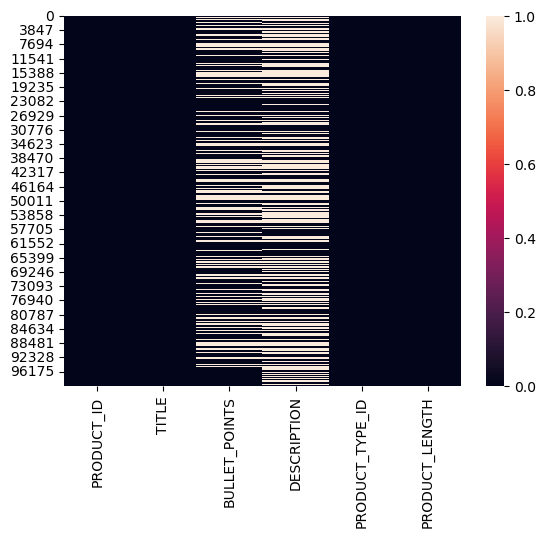

In [10]:
sns.heatmap(data.isnull())

DEALING WITH NULL VALUES

In [11]:
data=data.fillna(" ")
test=test.fillna(" ")
data.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,,,6112,598.424000


In [12]:
print(data["BULLET_POINTS"][0])
print(data["BULLET_POINTS"][1])
print(data["BULLET_POINTS"][2])

[LUXURIOUS & APPEALING: Beautiful custom-made curtains to decorate any home or office | Includes inbuilt tieback to hold the curtain | Completely finished and ready to hang on walls & windows,MATERIAL: Luxurious & versatile fabric with a natural finish | High colour fastness | State-of-the-art digital printing ensures colour consistency and prevents any fading | Eyelets; Cotton Canvas; Width 4.5feet (54inch) | Multicolour | PACKAGE: 2 Room Curtains Eyelets | SIZE: Height 5 feet (60 inch); SET OF 2 PCS,BLACKOUT CURTAIN: 100% opaque & heavy premium cotton canvas fabric | Tight knitted, long life & durable fabric | Printing only on front side with a plain colour back side,MADE TO PERFECTION: Large eyelets at the top to put hanging hooks | Perfectly tailored seams for durability | Refined stitching with a matching thread color,QUALITY ASSURED: Gentle wash with similar colors in cold water | Avoid direct sunlight to prevent fading | Dispatched after MULTIPLE QUALITY CHECKS]
[Harry Potter He

In [13]:
data["TITLE"].describe()

count            100000
unique            99858
top       Unknown Title
freq                  5
Name: TITLE, dtype: object

In [14]:
data["PRODUCT_LENGTH"].describe()

count    1.000000e+05
mean     2.327075e+03
std      8.591597e+04
min      1.000000e+00
25%      5.118110e+02
50%      6.653530e+02
75%      1.075000e+03
max      9.466000e+06
Name: PRODUCT_LENGTH, dtype: float64

Preporcessing DATA

(array([9.9973e+04, 9.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([1.0000000e+00, 3.1553430e+05, 6.3106760e+05, 9.4660090e+05,
        1.2621342e+06, 1.5776675e+06, 1.8932008e+06, 2.2087341e+06,
        2.5242674e+06, 2.8398007e+06, 3.1553340e+06, 3.4708673e+06,
        3.7864006e+06, 4.1019339e+06, 4.4174672e+06, 4.7330005e+06,
        5.0485338e+06, 5.3640671e+06, 5.6796004e+06, 5.9951337e+06,
        6.3106670e+06, 6.6262003e+06, 6.9417336e+06, 7.2572669e+06,
        7.5728002e+06, 7.8883335e+06, 8.2038668e+06, 8.5194001e+06,
        8.8349334e+06, 9.1504667e+06, 9.4660000e+06]),
 <BarContainer object of 30 artists>)

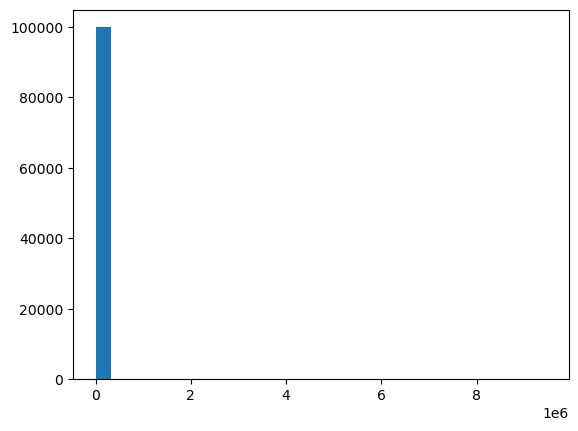

In [15]:
plt.hist(data['PRODUCT_LENGTH'],bins=30)

(array([1.6900e+02, 1.1900e+02, 4.5000e+01, 2.0900e+02, 1.5100e+02,
        1.0230e+03, 7.4500e+02, 2.2550e+03, 2.6760e+03, 4.5050e+03,
        1.8261e+04, 3.9254e+04, 1.8114e+04, 5.8910e+03, 2.6030e+03,
        1.9040e+03, 1.5480e+03, 2.1000e+02, 1.4200e+02, 6.5000e+01,
        2.9000e+01, 1.8000e+01, 2.7000e+01, 1.6000e+01, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+01]),
 array([ 0.69314718,  1.20548284,  1.71781851,  2.23015417,  2.74248984,
         3.2548255 ,  3.76716116,  4.27949683,  4.79183249,  5.30416815,
         5.81650382,  6.32883948,  6.84117515,  7.35351081,  7.86584647,
         8.37818214,  8.8905178 ,  9.40285347,  9.91518913, 10.42752479,
        10.93986046, 11.45219612, 11.96453178, 12.47686745, 12.98920311,
        13.50153878, 14.01387444, 14.5262101 , 15.03854577, 15.55088143,
        16.0632171 ]),
 <BarContainer object of 30 artists>)

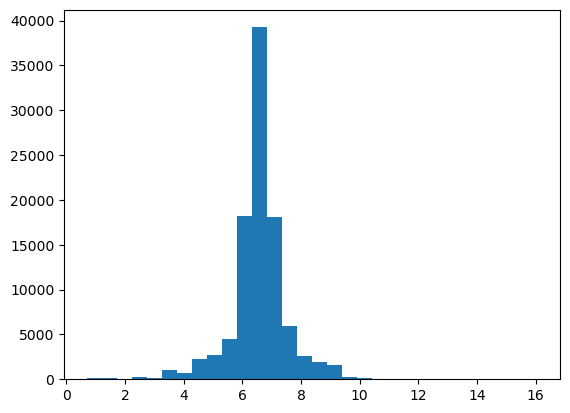

In [16]:
data["PRODUCT_LENGTH"]=np.log1p(data["PRODUCT_LENGTH"])
plt.hist(data['PRODUCT_LENGTH'],bins=30)

In [18]:
from tqdm import tqdm
# preprocessing item title 
def preprocess_title(text_col):
    preprocessed_names = []
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        preprocessed_names.append(sent.lower().strip())
    return preprocessed_names

# preprocessing item description 
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
def preprocess_desc(text_col):
    preprocessed_descs = []
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_descs.append(sent.lower().strip())
    return preprocessed_descs

#Cleaning category values
def clean_cat(cat_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(cat_values)

    cat_list = []
    for sentence in tqdm(cat_values.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('[','')
        sent = sent.replace(']','')
        sent = sent.replace('|',' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        cat_list.append(sent.lower().strip())
    
    return cat_list
data["TITLE"]=preprocess_title(data["TITLE"])
data["DESCRIPTION"]=preprocess_desc(data["DESCRIPTION"])
data["BULLET_POINTS"]=clean_cat(data["BULLET_POINTS"])



100%|██████████| 100000/100000 [00:01<00:00, 65305.95it/s]


########    TRAIN TEST SPLIT     #########

########    COUNT VECTORIZER     #########

######    TFIDF VECTORIZER     ####### 

In [19]:
vectorizer = TfidfVectorizer()

train_name_tfidf = vectorizer.fit_transform(data['TITLE'].values)
# cv_name_tfidf = vectorizer.transform(cv_df['TITLE'].values)
test_name_tfidf = vectorizer.transform(test['TITLE'].values)


# vectorizing item_description
vectorizer = TfidfVectorizer()

train_description_tfidf = vectorizer.fit_transform(data['DESCRIPTION'].values)
# cv_description_tfidf = vectorizer.transform(cv_df['DESCRIPTION'].values)
test_description_tfidf = vectorizer.transform(test['DESCRIPTION'].values)

#vectorizing bullet points
vectorizer = TfidfVectorizer()

train_bullet_tfidf = vectorizer.fit_transform(data['BULLET_POINTS'].values)
# cv_bullet_tfidf = vectorizer.transform(cv_df['BULLET_POINTS'].values)
test_bullet_tfidf = vectorizer.transform(test['BULLET_POINTS'].values)

In [20]:
print(train_name_tfidf.shape)
type(train_name_tfidf)

(100000, 110412)


scipy.sparse._csr.csr_matrix

In [21]:
temp=data["PRODUCT_ID"].values
print(temp.shape)

(100000,)


In [22]:
# train_df.head()

COULD HAVE USED STANDARD SCALER BUT DIDN'T SINCE ID's ARE UNIQUE VALUES

In [23]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# cols=['PRODUCT_ID','PRODUCT_TYPE_ID']
# train_df[cols]=sc.fit_transform(train_df[cols])

In [24]:
# train_df.head()

In [22]:
csr_train_pid=csr_matrix(pd.get_dummies(data[["PRODUCT_ID"]],sparse=True).values)
csr_train_ptid=csr_matrix(pd.get_dummies(data[["PRODUCT_TYPE_ID"]],sparse=True).values)

# # csr_cv_pid=csr_matrix(cv_df["PRODUCT_ID"])
# # csr_cv_ptid=csr_matrix(cv_df["PRODUCT_TYPE_ID"])

csr_test_pid=csr_matrix(pd.get_dummies(test[["PRODUCT_ID"]],sparse=True).values)
csr_test_ptid=csr_matrix(pd.get_dummies(test[["PRODUCT_TYPE_ID"]],sparse=True).values)

In [59]:
all_x_train=hstack((train_name_tfidf,train_description_tfidf,train_bullet_tfidf,csr_train_pid,csr_train_ptid)).tocsr().astype('float32')
# all_y_train=np.log1p(data["PRODUCT_LENGTH"])
all_y_train=data["PRODUCT_LENGTH"]
# x_cv=hstack((cv_name_tfidf,cv_description_tfidf,cv_bullet_tfidf,csr_cv_pid,csr_cv_ptid)).tocsr()
all_x_test=hstack((test_name_tfidf,test_description_tfidf,test_bullet_tfidf,csr_test_pid,csr_test_ptid)).tocsr().astype('float32')
#train_bullet_tfidf

In [61]:
print(all_x_train.shape)
print(all_y_train.shape)
print(all_x_test.shape)

(100000, 260970)
(100000,)
(734736, 260970)


In [21]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import LogisticRegression
# import lightgbm as lgb

In [150]:
X_train, X_test, y_train, y_test = train_test_split(all_x_train, all_y_train, test_size=0.2, random_state=42)

In [146]:
print(y_train[0])

7.662458412241126


In [ ]:
# rf=RandomForestRegressor()

In [39]:
# from scipy.stats import randint as sp_randint
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform
# lgb_model=lgb.LGBMRegressor(subsample=0.9)
# params = {'learning_rate': uniform(0, 1),
#           'n_estimators': sp_randint(200, 1500),
#           'num_leaves': sp_randint(20, 200),
#           'max_depth': sp_randint(2, 15),
#           'min_child_weight': uniform(0, 2),
#           'colsample_bytree': uniform(0, 1),
#          }
# lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=4, cv=3, random_state=42, 
#                                 scoring='neg_root_mean_squared_error', verbose=4, return_train_score=True)
# lgb_random = lgb_random.fit(X_train, y_train)

In [ ]:
# y_pred=lgb_random.predict(X_val)

In [40]:
# c=0
# for i in range(len(y_pred)):
#     if y_pred[i]<0:
#         y_pred[i]=0
# for i in y_pred:
#     if(i<0):
#         c+=1
# print(c)

ML

In [107]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 3)
]

In [135]:
type[y_test]

type[75721    6.670008
80184    5.926968
19864    6.613384
76699    6.369901
92991    5.755618
           ...   
32595    8.412055
29313    6.382746
37862    6.160027
53421    6.904812
42410    7.362518
Name: PRODUCT_LENGTH, Length: 20000, dtype: float64]

In [151]:
y_scaler = StandardScaler() 
y_train = (y_train.values.reshape(-1, 1)) #y_scaler.fit_transform
y_val = (y_test.values.reshape(-1, 1)) #y_scaler.transform

In [162]:
for i in y_val:
    print(i)

[6.67000757]
[5.92696802]
[6.61338422]
[6.36990098]
[5.75561762]
[3.04452244]
[5.59471138]
[6.2166061]
[6.2166061]
[9.23024103]
[8.45553053]
[6.74641213]
[4.02535169]
[5.97812798]
[7.20860034]
[6.74641213]
[9.03610602]
[6.89289741]
[6.43935037]
[7.17088848]
[6.32972091]
[5.62040087]
[6.74641213]
[9.03610603]
[7.86365127]
[6.78764767]
[6.31173481]
[5.91620206]
[6.38274821]
[5.11412003]
[6.39859493]
[6.74641213]
[6.62140565]
[6.4219019]
[6.07764224]
[6.85751406]
[7.09090982]
[3.93182563]
[7.58553498]
[6.55250789]
[7.09156323]
[6.76520244]
[7.09090982]
[9.10509096]
[6.43935037]
[5.75561762]
[6.67000757]
[6.71873733]
[6.39859493]
[6.42162227]
[6.93342303]
[6.06610809]
[7.4112783]
[6.68487744]
[6.74641213]
[6.2166061]
[6.89289741]
[7.17028307]
[6.67000757]
[6.39859493]
[6.50771245]
[6.8145429]
[6.42162227]
[6.40522846]
[6.80350526]
[6.34738921]
[6.62140565]
[3.93182563]
[5.97812798]
[8.92279162]
[6.39596919]
[5.97812798]
[6.44717907]
[5.97812798]
[6.26530121]
[6.2166061]
[6.42162227]
[6.293

In [64]:
# a=np.array(X_train)
# b=X_train.toarray()
# X_train=X_train.todense()
# y_train=y_train.todense()
# X_test=X_test.todense()
# y_test=y_test.todense()

In [155]:
model_in = Input(shape = (260970,), dtype = 'float32', sparse = True)
out = Dense(256, activation = 'relu')(model_in)
out = Dropout(0.2)(out)
out = Dense(128, activation = 'relu')(out)
out = Dense(64, activation = 'relu')(out)
out = Dense(32, activation = 'relu')(out)
out = Dense(16, activation = 'relu')(out)
model_out = Dense(1)(out)
    
model = Model(model_in, model_out)
    
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.001))
    
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 260970)]          0         
                                                                 
 dense_36 (Dense)            (None, 256)               66808576  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 16)                528 

In [156]:
model.fit(X_train, y_train, batch_size = 512, epochs = 20, verbose = 1, validation_data = (X_test, y_val), callbacks = callbacks)

Epoch 1/20
157/157 [==============================] - 91s 573ms/step - loss: 8552.2246 - val_loss: 37.5781
Epoch 2/20
157/157 [==============================] - 86s 544ms/step - loss: 242.8543 - val_loss: 114.0973
Epoch 3/20
157/157 [==============================] - 89s 566ms/step - loss: 212.1001 - val_loss: 12.6248
Epoch 4/20
157/157 [==============================] - 93s 593ms/step - loss: 89.5111 - val_loss: 861.5825
Epoch 5/20
157/157 [==============================] - 91s 577ms/step - loss: 92.8255 - val_loss: 67.5330
Epoch 6/20
157/157 [==============================] - 92s 586ms/step - loss: 95.6450 - val_loss: 8.9056
Epoch 7/20
157/157 [==============================] - 92s 587ms/step - loss: 67.0220 - val_loss: 93.7543
Epoch 8/20
157/157 [==============================] - 91s 580ms/step - loss: 124.4185 - val_loss: 8.7475
Epoch 9/20
157/157 [==============================] - 91s 582ms/step - loss: 21.2217 - val_loss: 10.3838
Epoch 10/20
157/157 [=============================

In [158]:
predictions = model.predict(X_test)[:, 0]
y_pred = (predictions.reshape(-1, 1))[:, 0]

625/625 [==============================] - 2s 3ms/step


In [159]:
c={}
for i in (y_pred):
    print(i)
print(len(c))

11.628879
8.246249
4.3720126
3.579349
11.533908
10.800876
7.5274386
6.831577
6.840427
5.5300326
8.105197
9.808566
4.407657
11.574496
5.9910007
4.617145
7.92728
6.4501376
2.5651736
7.3387485
4.8881564
7.6622043
11.447665
6.8983493
4.7547946
3.6960177
3.7874942
9.954135
9.710666
11.276095
8.953525
2.7508883
2.400165
4.373401
4.598331
7.6413302
4.471378
9.971286
7.9161105
7.8743625
7.82645
9.259921
6.493625
10.808383
5.853275
9.345065
11.322238
11.272983
8.9828825
4.38467
7.0844455
6.9163547
9.006991
8.044711
9.279574
7.07175
8.779391
10.663302
10.551364
2.504871
9.006503
7.698459
4.382602
2.771915
4.599445
4.142978
1.6901354
8.948581
9.297336
7.944431
4.236957
10.014316
1.3425325
9.897555
1.3514932
8.895602
7.6514773
5.130985
4.258701
7.0029025
7.1748996
1.215135
5.340976
9.921359
2.3398318
4.727329
6.648166
4.3396106
3.3546786
3.6665683
8.139255
3.390201
1.7912935
10.363559
4.3701053
4.5918612
8.283542
8.281955
6.4650607
6.068088
4.5390964
8.779147
3.6864352
11.050754
6.1366305
9.106357

In [164]:
sqrt(mse(y_val,y_pred))

3.0183606587061633